# ABM Infection model with Mesa

## Model using a grid

* https://github.com/projectmesa/mesa/wiki/Mesa-Packages
* https://github.com/metalcorebear/Mesa-SIR
* https://github.com/projectmesa/mesa/blob/master/examples/virus_on_network/virus_on_network/model.py
* https://github.com/Corvince/mesa-geo
* https://www.youtube.com/watch?v=lcySLoprPMc&t=202s
* https://www.sciencedirect.com/science/article/pii/S1755436517300221
* https://nbviewer.jupyter.org/gist/jlstevens/9c7835e4e21c5d844ded

In [1]:
import time, enum
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [2]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [3]:
class InfectionModel(Model):
    """Un modelo que muestra la infeccion de la malaria."""

    def __init__(self, N=5, width=10, height=10, ptrans=0.5,
                 death_rate=0.02, recovery_days=21,
                 recovery_sd=7):

        self.num_agents = N
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Se crea los agentes
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Añadir los agentes a la grilla
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            # Hacer unos agentes infectados al comienzo
            infected = np.random.choice([0,1], p=[0.02,0.98])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [4]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 0

## Define an agent class

In [5]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,40)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED
            #print (self.model.schedule.time,self.recovery_time,t)

    def contact(self):
        """Find close contacts and infect"""
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            #other = self.random.choice(cellmates)
            for other in cellmates:
                #print (self.model.schedule.time,self.state,other.state)                
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()
                
    def step(self):
        self.status()
        self.move()
        self.contact()


## Model class

In [6]:
class GridInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, width=10, height=10, ptrans=0.5, 
                 progression_period=3, progression_sd=2, death_rate=0.0193, recovery_days=21,
                 recovery_sd=7):
        
        self.num_agents = N
        self.initial_outbreak_size = 1
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.98,0.02])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
            
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini}, 
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [7]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infectado','Muerto']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)

In [9]:
pop=200
steps=150
st=time.time()
model = GridInfectionModel(pop, 20, 20, ptrans=0.5)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))

0.23405122756958008
      Susceptible  Infectado
Step                        
0             198          2
1             198          2
2             198          2
3             198          2
4             198          2
...           ...        ...
145            45         14
146            47         12
147            47         12
148            48         11
149            48         11

[150 rows x 2 columns]


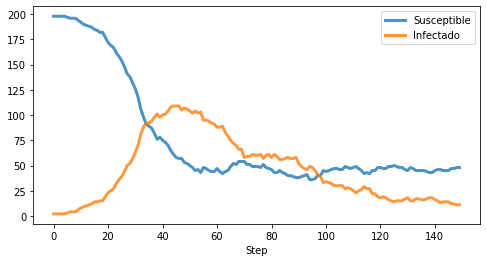

In [10]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

## Bokeh plots

In [117]:
def grid_values(model):
    """Get grid states"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        agents, x, y = cell
        c=None
        for a in agents:
            c = a.state
        agent_counts[x,y] = c
    df=pd.DataFrame(agent_counts)  
    return df

st=time.time()
x=grid_values(model)
print (time.time()-st)

0.0


In [23]:
def plot_cells_bokeh(model):
    """Plot model grid values as a grid"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model) 
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]    
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    colors = Category10[3]
    mapper = LinearColorMapper(palette=colors, low=df.value.min(), high=df.value.max())
    p = figure(plot_width=500,plot_height=500, tools=[hover], x_range=(-1,w), y_range=(-1,w))
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "black"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)

Bokeh(Figure)

In [24]:
def plot_states_bokeh(model,title=''):
    """Plot cases per country"""
        
    X = get_column_data(model)
    X = X.reset_index()
    source = ColumnDataSource(X)
    i=0
    colors = Category10[3]
    items=[]
    p = figure(plot_width=600,plot_height=400,tools=[],title=title,x_range=(0,100))        
    for c in X.columns[1:]:
        line = Line(x='Step',y=c, line_color=colors[i],line_width=3,line_alpha=.8,name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c,[glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right',   
                items=items))
    p.background_fill_color = "#e1e1ea"
    p.background_fill_alpha = 0.5
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p

p = plot_states_bokeh(model)
#pn.pane.Bokeh(p)

In [25]:
plot_pane = pn.pane.Bokeh()
grid_pane = pn.pane.Bokeh()
pn.Row(plot_pane,grid_pane,sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Bokeh(None)
    [1] Bokeh(None)

## Run the model with plot updates

In [27]:
steps=100
pop=400
st=time.time()
model = InfectionModel(pop, 20, 20, ptrans=0.25, death_rate=0.01)
for i in range(steps):
    model.step()    
    p1=plot_states_bokeh(model,title='step=%s' %i)
    plot_pane.object = p1
    p2=plot_cells_bokeh(model)
    grid_pane.object = p2
    time.sleep(0.5)
print (time.time()-st)

59.38318204879761


## Explore parameters 

In [28]:
def compute_max_infections(model):
    X=get_column_data(model)
    try:
        return X.Infected.max()
    except:
        return 0

compute_max_infections(model) 

226

In [29]:
from mesa.batchrunner import BatchRunner
fixed_params = {
    "width": 20,
    "height": 20,
    "N": 300,
}
#variable_params = {"N": range(20, 200, 10)}
variable_params = {"ptrans": np.arange(.05, .9, .1)}
batch_run = BatchRunner(
    InfectionModel,
    variable_params,
    fixed_params,
    iterations=3,
    max_steps=100,
    model_reporters={"Inf": compute_max_infections}
)

batch_run.run_all()

27it [00:08,  3.23it/s]


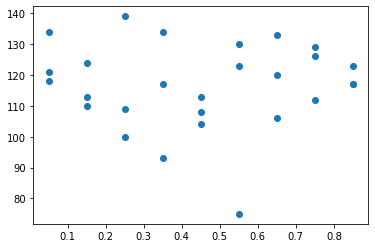

In [30]:
run_data = batch_run.get_model_vars_dataframe()
#run_data#.head()
plt.scatter(run_data.ptrans, run_data.Inf)